<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/gan/gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will build a generative adversarial network (GAN) trained on the MNIST dataset. From this we will be able to generate new handwritten digits. 

The process will be broken down into the following steps:

  1. Load and visualize the dataset
  2. Define a model
      - Define a discriminator network
      - Define a generator network
      - Build complete network
  3. Specify loss functions and optimizers
  4. Train the model
      - Discriminator training
          * Compute the discriminator loss on real images
          * Generate fake images
          * Compute the discriminator loss on fake, generated images
          * Add up real and fale losses
          * Update discriminator's weights (backprop + optimization)
      - Generator training
          * Generate fake images
          * Compute the discriminator loss on fake images using flipped labels
          * Update generator's weights (backprop + optimization)
  5. Generate new images


In [122]:
# import required libraries
import torch
import torchvision

import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("CUDA is available!")
else:
  print("CUDA is not available!")

device = torch.device("cuda") if train_on_gpu else torch.device("cpu")

CUDA is available!


In [124]:
# settings
    
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

random_seed = 125
set_all_seeds(random_seed)

### Load and visualiza dataset

In [125]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load dataset from torchvision.datasets 
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# number of subprocess to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# prepare dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

# image classes in the dataset
classes = ['0','1','2','3','4','5', '6','7','8','9']
num_classes = len(classes)

In [126]:
# print out some data stats

print('Number of training images:', len(train_data))

for inputs, targets in train_loader:
  print("Image batch dimensions:", inputs.shape)
  print("Image label dimensions:", targets.shape)
  print("Class labels of 10 examples:", targets[:10])
  break

Number of training images: 60000
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


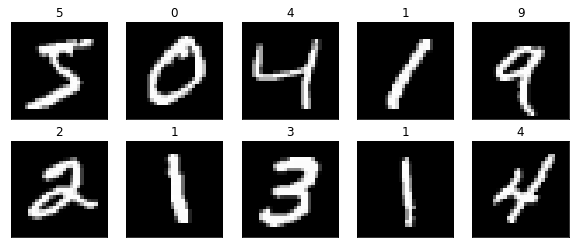

In [127]:
# visualize a batch of training data

def imshow(img):
  plt.imshow(np.squeeze(img), cmap="gray")

# obtain one batch on training images
dataiter = iter(train_loader)
inputs, targets = dataiter.next()
inputs = inputs.numpy()

# plot some images in the batch along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  imshow(inputs[idx])
  ax.set_title(str(targets[idx].item()))

### Define the model

In [128]:
# Discriminator network

import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_dim * 4)
    self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
    self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, output_size)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
    out = self.fc4(x)
    return out

In [129]:
# Generator network

class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
    self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
    self.fc4 = nn.Linear(hidden_dim * 4, output_size)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
    out = F.tanh(self.fc4(x))
    return out

In [130]:
# Discriminator hyparameters

# size of the input image to discriminator 
input_size = 28*28
# size of the discriminator output
d_output_size = 1
# size of the last hidden layer
d_hidden_size = 32

# Generator hyperparameters

# size of the latent vector
z_size = 100
# size of the generator output
g_output_size = 28*28
# size of the first hidden layer
g_hidden_size = 32

# Build complete network
D = Discriminator(input_size, d_hidden_size, d_output_size).to(device)
G = Generator(z_size, g_hidden_size, g_output_size).to(device)

print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Specify loss functions and optimizers

In [131]:
# real image loss
def real_loss(D_out, smooth=False):
  batch_size = D_out.size(0)
  if smooth:
    labels = torch.ones(batch_size) * 0.9 # label smoothing (from 1.0 to 0.9)
  else:
    labels = torch.ones(batch_size) # real label = 1
  # move labels to the right device
  labels = labels.to(device)
  # binary cross entropy with logits loss
  criterion = nn.BCEWithLogitsLoss()
  # calculate loss
  loss = criterion(D_out.squeeze(), labels)
  return loss

# fake image loss
def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size) # fake label = 0
  labels = labels.to(device)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  return loss 

In [132]:
import torch.optim as optim

# specify optimizer
lr = 0.002

# optimizer for discriminator
d_optimizer = optim.Adam(D.parameters(), lr)
# optimizer for generator
g_optimizer = optim.Adam(G.parameters(), lr)

### Train the model

In [133]:
import pickle as pkl

# number of epochs to train the model
num_epochs = 100

print_every = 400

# track training losses
G_losses, D_losses = [], []
# track generated fake samples
samples = []

# Get some fixed data / latent (noise) for sampling. These are images that are held
# constant throughout training for evaluating / visualizing the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.to(device)

# set models to training mode
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_idx, (real_images, _) in enumerate(train_loader):

        batch_size = real_images.size(0)

        # move images to the right device        
        real_images = real_images.to(device)
        # rescale images from [0,1) to [-1, 1)
        real_images = real_images * 2 - 1 
        
        # ----------- train the discriminator ------------

        # clear the gradients of all optimized variables
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # compute the discriminator losses on real images
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # generate fake images
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            z = z.to(device)
            fake_images = G(z)
        
        # compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up losses
        d_loss = d_real_loss + d_fake_loss
        # backward pass
        d_loss.backward()
        # update parameters
        d_optimizer.step()
        
        # ----------- train the generator -------------

        # clear the gradients of all optimized variables
        g_optimizer.zero_grad()
        
        # 1. Train with fake images with flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z)
        
        # compute the discriminator losses on fake images with flipped labels
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        
        # backward pass
        g_loss.backward()
        # update parameters
        g_optimizer.step()

        if batch_idx % print_every == 0:
          print('Epoch [{} / {}] | d_loss: {:.6f} | g_loss: {:.6f}'.format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    # append discriminator loss and generator loss after each epoch
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())
    
    # set to evaluation mode
    G.eval()
    # generate samples
    sample_z = G(fixed_z)
    # save generated samples
    samples.append(sample_z)
    # set back to train mode
    G.train()

# save training generator samples
with open("samples.pkl", "wb") as f:
  pkl.dump(samples, f)

Epoch [1 / 100] | d_loss: 1.383274 | g_loss: 0.687500


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [1 / 100] | d_loss: 0.840853 | g_loss: 2.954487
Epoch [1 / 100] | d_loss: 1.270126 | g_loss: 1.239476
Epoch [1 / 100] | d_loss: 0.944049 | g_loss: 4.376801
Epoch [1 / 100] | d_loss: 1.823495 | g_loss: 0.949570
Epoch [2 / 100] | d_loss: 1.157572 | g_loss: 0.983028
Epoch [2 / 100] | d_loss: 1.280657 | g_loss: 0.941088
Epoch [2 / 100] | d_loss: 1.080840 | g_loss: 1.243992
Epoch [2 / 100] | d_loss: 1.229027 | g_loss: 1.037092
Epoch [2 / 100] | d_loss: 1.074636 | g_loss: 1.082520
Epoch [3 / 100] | d_loss: 1.182455 | g_loss: 1.471146
Epoch [3 / 100] | d_loss: 1.043794 | g_loss: 1.493513
Epoch [3 / 100] | d_loss: 1.016053 | g_loss: 1.508995
Epoch [3 / 100] | d_loss: 1.274924 | g_loss: 1.365371
Epoch [3 / 100] | d_loss: 1.053508 | g_loss: 1.848176
Epoch [4 / 100] | d_loss: 1.213647 | g_loss: 1.346846
Epoch [4 / 100] | d_loss: 1.250445 | g_loss: 1.134377
Epoch [4 / 100] | d_loss: 1.037782 | g_loss: 1.253971
Epoch [4 / 100] | d_loss: 1.291967 | g_loss: 1.519547
Epoch [4 / 100] | d_loss: 0.

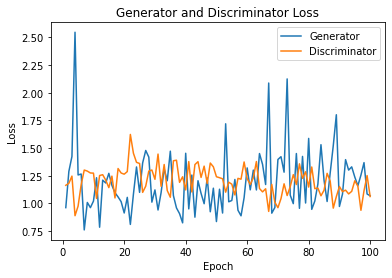

In [141]:
# plot discriminator and generator loss for each epoch
epochs = range(1, num_epochs+1)
plt.plot(epochs, G_losses, label="Generator")
plt.plot(epochs, D_losses, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss")
plt.legend()
plt.show()

In [135]:
# load saved samples from generator taken while training
with open("samples.pkl", "rb") as f:
  samples = pkl.load(f)

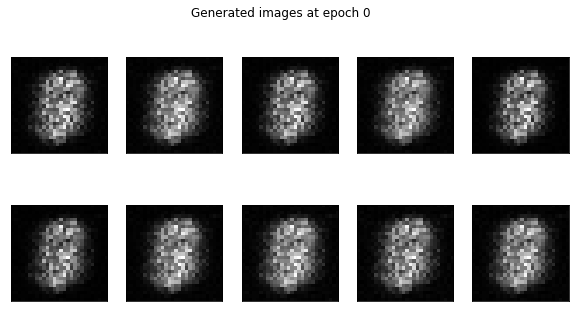

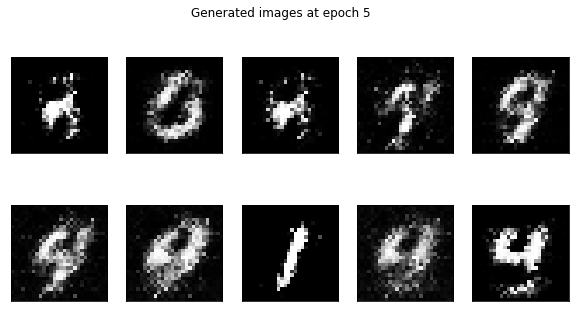

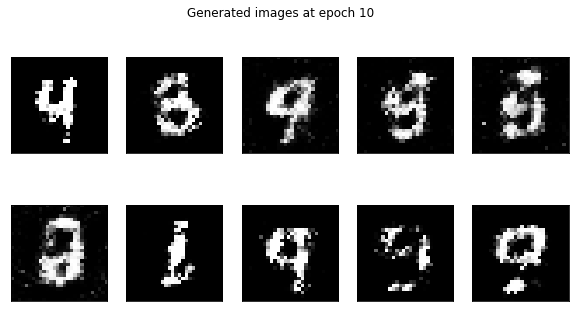

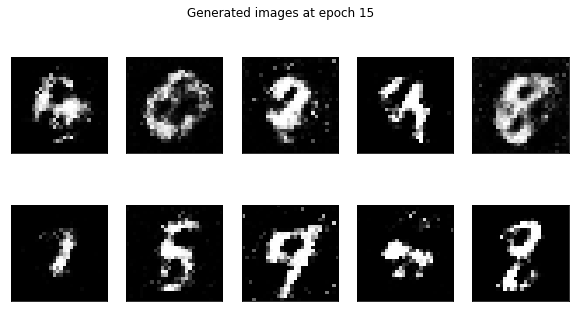

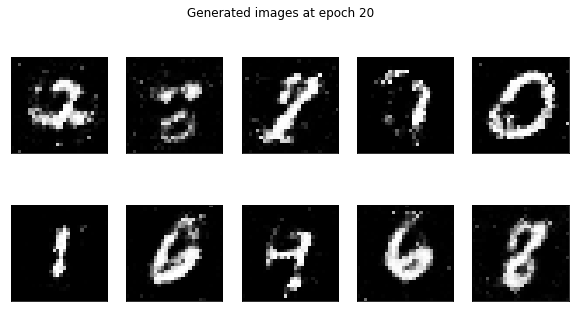

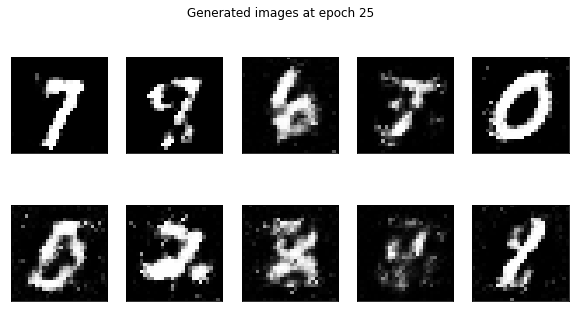

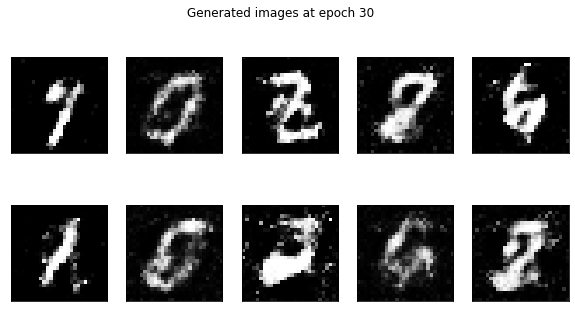

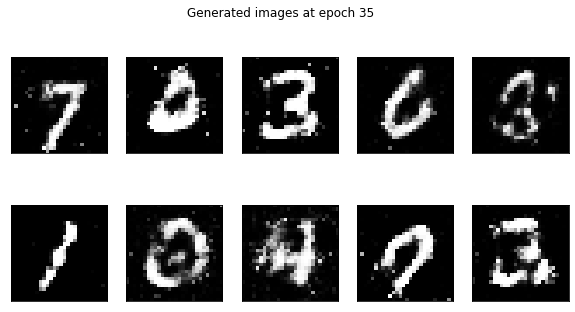

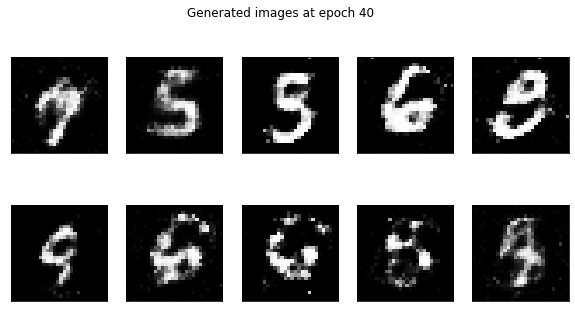

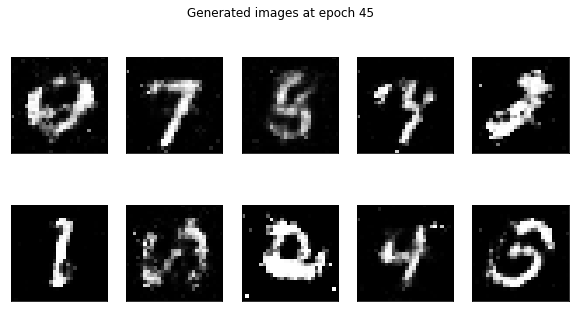

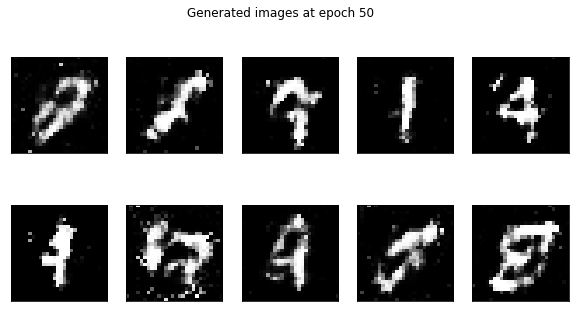

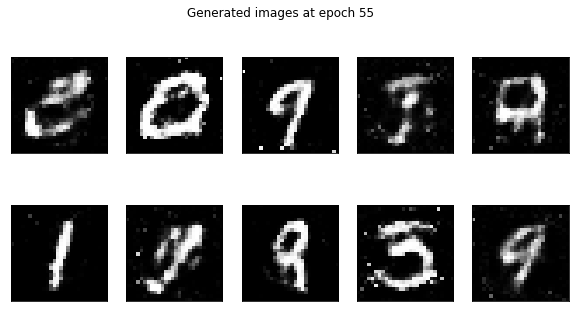

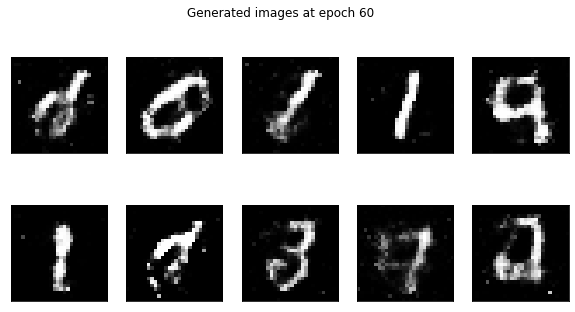

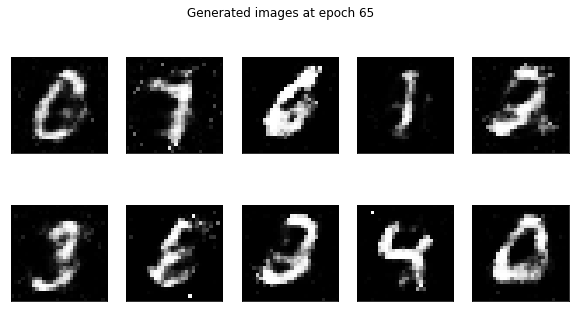

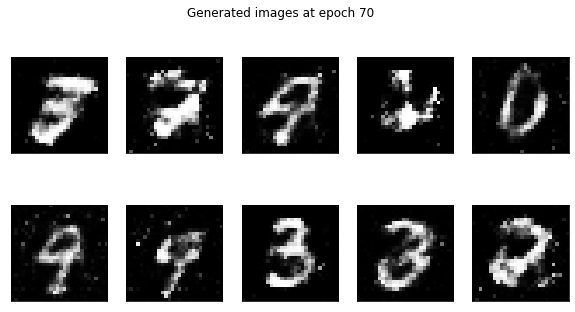

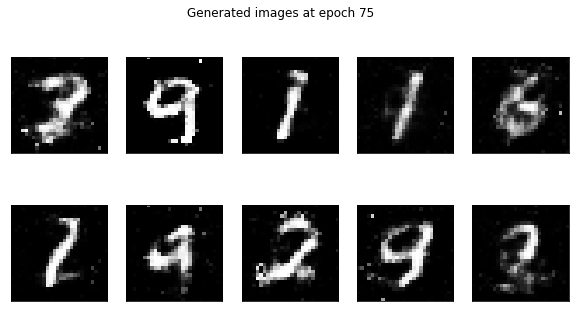

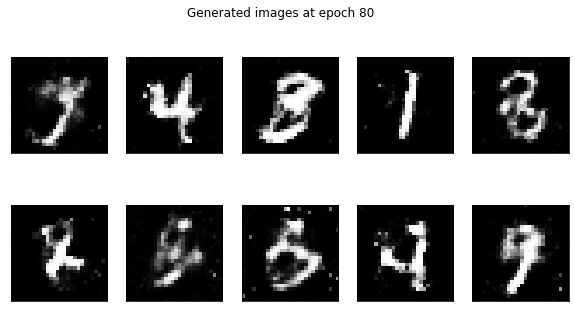

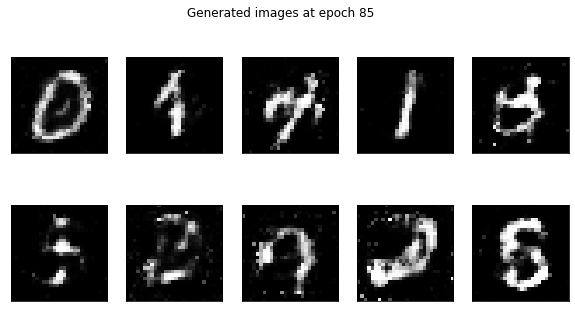

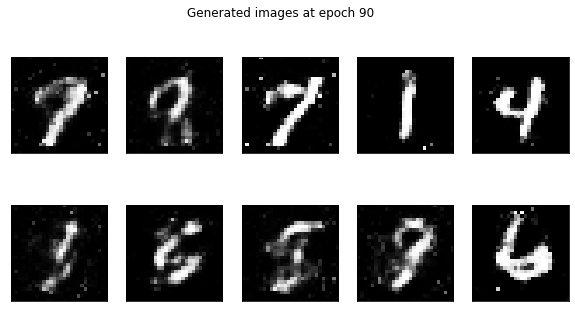

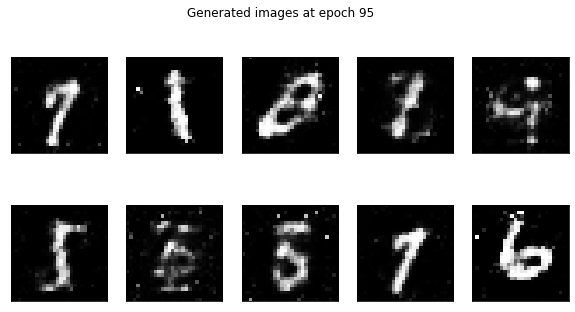

In [136]:
# vilualize generator's progress (generated samples)
# after every 10 epochs as the model was training

for epoch in range(0, num_epochs, 5):
    fig, axes = plt.subplots(figsize=(10,5), nrows=2, ncols=5, sharey=True, sharex=True)
    fig.suptitle(f'Generated images at epoch {epoch}')
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        ax.imshow(img.reshape((28,28)), cmap='gray')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

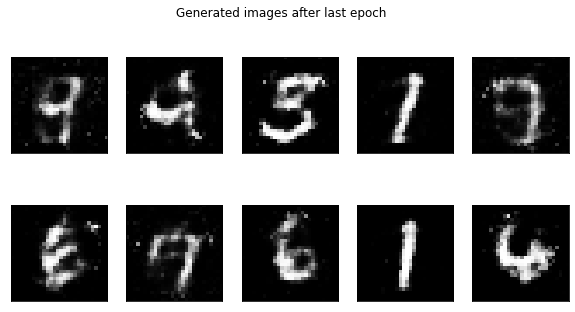

In [137]:
# visualize generated samples at the last epoch
fig, axes = plt.subplots(figsize=(10,5), nrows=2, ncols=5, sharey=True, sharex=True)
fig.suptitle('Generated images after last epoch')
for ax, img in zip(axes.flatten(), samples[num_epochs-1]):
    img = img.detach().cpu().numpy()
    ax.imshow(img.reshape((28,28)), cmap='gray')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

### Generate new images

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


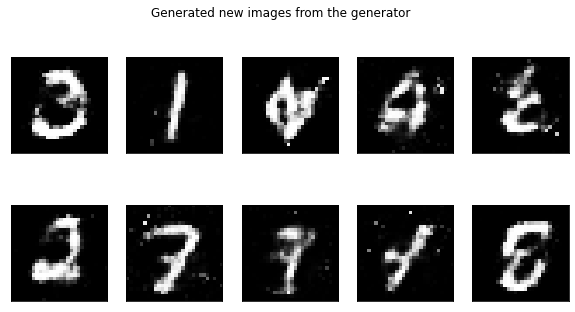

In [138]:
# new latent vectors

sample_size = 16
size_z = 100 # size of the latent vector
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()
rand_z = rand_z.to(device)

G.eval()
rand_images = G(rand_z)

fig, axes = plt.subplots(figsize=(10,5), nrows=2, ncols=5, sharey=True, sharex=True)
fig.suptitle('Generated new images from the generator')
for ax, img in zip(axes.flatten(), [rand_images][0]): # 0 --> we only have one batch of samples
    img = img.detach().cpu().numpy()
    ax.imshow(img.reshape((28,28)), cmap='gray')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)